**Base de datos Area/Biomasa analisis y Fusion**

En este notebook se detallara el proceso para la depuracion y analisis de datos, de la area y biomasa por hoja del proyecto. Se hace un modelo por especie, aunque no se descarta la opcion de un modelo global.

Aparte de hace un modelo con los datos de material particulado, Biomasa estimada de hojas y area por especie. La idea es fusionar los modelos resultantes en uno mas general. 

En general se tiene que la estructura de los modelos es la siguiente(hay que tener en cuenta que los modelos de area foliar material particulado pueden variar de uno lineal):

Biomasa foliar ($B_f$) segun DAP:

> $B_f=\ln(\beta_1+\beta_0DAP) $

Area foliar ($A_f$) segun $B_f$:

> $A_f=\ c_0+\ m_0B_f $

Material particualdo ($M$)segun $A_f$:

> $M=\ c_1+\ m_1A_f $


Con lo anterior la estructura general del modelo final seria:

> $M=m_x\ln(\beta_1+\beta_0DAP)+c $


Material particualdo ($M$)segun $A_f$:

> $ln(M) = ln(A_f) + TipoHoja + Especie$


In [ ]:

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Codigo para arreglo de datos**

## **Funciones base area y biomasa**

Se detallan las funciones que se usaran para manejar los datos, las funciones estan diseñadas para manejar especificamente el formato de datos que tenemos


### Principal (trabajo)

Funcion que retorna los resultados de un modelo de regresion lineal por especie para la base de datos de area y biomasa foliar

Entradas:

- data: dataframe con los datos de area y biomasa
- resumido: Si los datos de area biomasa no vienen crudos si no tratados ya con un paso de resumen, por defecto se asume que estan resumidos
- limpiar: es el percentil superior o inferior usado como limite para eliminar outliars, cualquier cosa dentro de esos percentiles se eliminaria, por defecto no se hace limpieza, si se hace se recomienda eliminar datos 3 desviaciones estandar alejados de la media
- alpha: significancia estadistica seleccionada, afecta los coeficientes de la regresion, se asume 0.05 por defecto

Salidas:

- resumen: Dataframe con los datos de la regresion 
- residuals: Residuales de la regresion por especie
- original: Dataframe con los datos analizados para la regresion



In [ ]:
def trabajo(data,resumido=True,limpiar=None,alpha=0.05):
    
    resumen = data
    #Se checkea si los datos estan resumidos o no
    if resumido == False:
        resumen=sumarrry(data)

    resumen=resumen.loc[resumen.loc[:,'Biomasa(g)'] != 0,:] #Se excluyen los valores sin biomasa ya que de estos no se puede hacer una relacion Area/Biomasa
    resumen.loc[:,'AreaSobreBiomas']=resumen.loc[:,'Area(cm2,algoritmoFlorian)']/resumen.loc[:,'Biomasa(g)']#Se crea una columna con la relacion Area/Biomasa de todos los datos
    resumen.rename(columns={'Area(cm2,algoritmoFlorian)':'Area_cm2', #Se cambia el nombre de las columnas a uno mas conveniente
                            'Biomasa(g)':'Biomasa_g'}, inplace=True)
    
    #Se chequea si se quiere limpiar o no los datos
    if limpiar != None:
        resumen=limpieza(resumen,limpiar)
    original=resumen
    
    resumen,residuals=regresioness(resumen,alpha)

    resumen.loc[resumen.loc[:,'pval_coef'] > alpha,'biomas_coef']=0
    resumen.loc[resumen.loc[:,'pval_intercept'] > alpha,'intercept']=0

    resumen=resumen.sort_values(['R2'],axis=0,ascending=False)
    resumen.reset_index(inplace=True)

    return resumen,residuals,original

### Primarias

Las funciones aqui estan diseñadas para funcionar dentro de la funcion principal


Funcion *sumarrry*

Funcion para sumar en base a valores de columnas como condicion se devuelven datos de area y de biomasa por individuo, esto se hace sobre los datos crudos de area y biomasa recogidos

Entradas:

- data: datos crudos de area y biomasa por hoja

Salidas:

- datafin: datos resumidos de area y biomasa por individuo, sobre estos se pueden llevar a cabo analisis subsecuentes

In [ ]:
def sumarrry(data):
    datafin=data.iloc[0:1,:] #Se crea un nuevo dataframe donde se pondran los datos
    datafin.drop(['Fecha escaneo',
       'Numero de escaneo',
       'Biomasa +  Aluminio(g)', 'Aluminio(g)',
       'Observacion'],axis=1, inplace=True)#Se borrran las columnas innecesarias
    for i in data.loc[:,"Especie"].unique():#Se evalua en base a los valores unicos de las columnas de 
                                            #condicion, asi para los demas
        for y in data.loc[:,"Individuo"].unique():
            for h in data.loc[:,"Hoja"].unique():
                
                #Se saca la sumatoria del area y de la biomasa en base a las condiciones
                A=data.loc[(data.loc[:'Especie'] == i) & (data.loc[:'Individuo'] == y) & (data.loc[:"Hoja"] == h),
                          'Area(cm2,algoritmoFlorian)'].sum()
                B=data.loc[(data.loc[:'Especie'] == i) & (data.loc[:'Individuo'] == y) & (data.loc[:"Hoja"] == h),
                          'Biomasa(g)'].sum()
                
                #Hay combinaciones de condiciones que no existen, python las lee como "0", asi que 
                #descarto esos, aunque hay muchos casos donde no hay biomasa, la area siempre esta
                #esos casos no se descartan
                if A == 0 and B == 0:
                    pass
                else:
                    #Se asigna en la respectiva columna el respectivo dato, poco mas
                    datafin.loc[len(datafin.index)]=datafin.loc[0]
                    datafin.loc[len(datafin.index)-1,"Especie"]=i
                    datafin.loc[len(datafin.index)-1,"Individuo"]=y
                    datafin.loc[len(datafin.index)-1,"Hoja"]=h
                    datafin.loc[len(datafin.index)-1,"Area(cm2,algoritmoFlorian)"]=A
                    datafin.loc[len(datafin.index)-1,"Biomasa(g)"]=B
    #Se devuelve el dataframe, listo para guardarse.             
    return datafin

Funcion *limpieza*

Funcion para limpiar outliars de la regresion usando de limite el percentil superior o inferior de la distribucion, 3 desviaciones estandar es lo "ideal".

Para la remocion se usa la relacion $area/biomasa$ poor individuo y en base a estos datos se hace la remocion del percentil de la distribucion, esta relacion asemeja a la pendiente de una regresion lineal por lo que una desviacion muy grande de esta distribucion seria un proxy de outliars. El metodo funciono en mejorar los ajustes de regresion por especie. 

En la funcion trabajo se devuelve el numero de datos usados para la regresion, esos datos serian descontando los eliminados por esta funcion, si es que se hace una limpieza.

Entradas:

- datas: datos de area y biomasa por individuo
- limite: percentil superieror e infere

In [ ]:
def limpieza(datas,limite):
    datos=pd.DataFrame(columns=datas.columns)
    for i in datas.loc[:,"Especie"].unique():
        a=datas[datas.loc[:,'Especie'] == i ]#Analizo solo una especie
        #print(a)
        q_hi= a.loc[:,'AreaSobreBiomas'].quantile(1-limite)#creo los limites por especie
        q_low = a.loc[:,'AreaSobreBiomas'].quantile(limite)
        #print(q_hi,q_low)
        a = a.loc[(a.loc[:,'AreaSobreBiomas'] <= q_hi) & (a.loc[:,'AreaSobreBiomas'] >= q_low),:]#filtro los datos
        #print(a) 
        datos=datos.append(a,ignore_index=True)#los meto en la primera base
    return datos  

Funcion *regresioness*

Funcion que hace regresiones lineales de area vs biomasa por especie, devuelve datos importantes de la regresion como su R2 y el p-value de los coeficientes de la regresion.


Entradas:
- data: Datos de area y biomasa foliar por especie

Salidas:

- datos: Dataframe nuevo, diferente al de entrada que contiene datos de regresion por especie, incluyendo:

1.   $R^2$: de la regresion por especie 
2.   numero de hojas por especie usado  en la regresion
3.   pendiente de la regresion lineal
4.   intercepto de la regresion lineal
5.   p-value de la pendiente
6.   p-value del intercepto
7.   p-value de prueba de normalidad de datos, se hace una prueba shapiro-wilk






In [ ]:
def regresioness(datas,alpha):
    datos=pd.DataFrame(columns=["Especie","R2","numero_hojas","biomas_coef",
                                "intercept","pval_coef","pval_intercept","pval_norm"])
    residuals=[]
    for i in datas.loc[:,"Especie"].unique():
        #Numero de datos usados
        numero_hojas=len(datas[datas.loc[:,'Especie'] == i ])
        #Se hace el modelo y se ajusta
        modelo=ols('Area_cm2 ~ Biomasa_g', data=datas[datas.loc[:,'Especie'] == i ]).fit()

        if modelo.pvalues['Intercept']<=alpha:
            modelo=ols('Area_cm2 ~ Biomasa_g', data=datas[datas.loc[:,'Especie'] == i ]).fit()

        #Se sacan datos de interes
        coef= modelo.params['Biomasa_g']
        intercept=modelo.params['Intercept']
        pval_coef=modelo.pvalues['Biomasa_g']
        pval_intercept=modelo.pvalues['Intercept']

        pval_norm=stats.shapiro(modelo.resid)[1]
        datos=datos.append(pd.DataFrame([[i, modelo.rsquared_adj,numero_hojas,coef,
                                          intercept,pval_coef,pval_intercept,pval_norm]],
                                        columns=["Especie","R2","numero_hojas","biomas_coef",
                                "intercept","pval_coef","pval_intercept","pval_norm"]),
                           ignore_index=True)
        residuals.append(modelo.resid)
    return datos,residuals

Funcion *scatterplots*

Funcion para hacer scatterplots de los datos por especie que se usaron en la regresion, esta funcion puede ser reemplazada por un metodo ya existente en statsmodels

Entradas:
- datas: Dataframe con los datos con los que se hizo la regresion, por especie se haran los scatterplot

In [ ]:
def scatterplots(datas):
    for i in datas.loc[:,"Especie"].unique():
        a=datas[datas.loc[:,'Especie'] == i ]
        plt.figure(figsize=(8,8),dpi=100)
        a.plot.scatter(x='Area',y='Biomasa_g')
        plt.ylabel(i)

Funcion *area_biomas_especie*

Su objetivo era asignar por especie un promedio de relacion area biomasa, que es distinto a generar un modelo de regresion, esto ultimo es preferible, pero la idea de la relacion fue primera y este es su remanente

Entradas:

- data: Dataframe con datos de area y biomasa por hoja por especie

Salida

- data_res: Dataframe con los datos resumidos de relacion area - biomasa por especie



In [ ]:
def area_biomas_especie(data):
    data['n_Hojas']=np.nan
    data_res=pd.DataFrame(columns = data.columns)
    data_res.drop(columns=['Individuo','Hoja'],inplace=True)
    for i in data.loc[:,"Especie"].unique():

        bool_mask = (data.loc[:,'Especie'] == i) 

        Area = data.loc[bool_mask,"Area_cm2"].mean()
        biomasa = data.loc[bool_mask,'Biomasa_g'].mean()
        AreaSobreBiomas = data.loc[bool_mask,'AreaSobreBiomas'].mean()
        n = len(data.loc[bool_mask])

        serie= pd.DataFrame([[i,Area,biomasa,AreaSobreBiomas,n]],columns=['Especie',
                                                'Area_cm2','Biomasa_g','AreaSobreBiomas','n_Hojas'])
        data_res = data_res.append(serie,ignore_index=True)
    
    return data_res

## **Funciones material particualdo area**

### Funcion *regresion_matrial25_spp*

Esta funcion hara regresiones de area de individuo vs material particulado 2.5 um por especie y tomando en cuenta la naturaleza de los datos que se presentan

Spoiler: estas regresiones no son muy buenas, los datos no parecen tener relaciones lineales 

Entradas:

- data: Dataframe de datos de material particulado, area y biomasa foliar estimada

Salidas:

- datos: Dataframe con los resultados de la regresion, incluyendo:

1.   $R^2$: de la regresion por especie 
2.   numero de individuos por especie usado  en la regresion
3.   pendiente de la regresion lineal
4.   intercepto de la regresion lineal
5.   p-value de la pendiente
6.   p-value del intercepto
7.   p-value de prueba de normalidad de datos, se hace una prueba shapiro-wilk

- ignorados: Algunas especies tenian muy pocos datos para hacer una regresion y se ignoraron, en esta lista se encuentran nombradas esas especies

In [ ]:


def regresion_material25_spp(data):
    datos=pd.DataFrame(columns=["Especie","R2","numero_individuos","area_coef_25",
                                "intercept_25","pval_coef_25","pval_intercept_25","pval_norm"])
    
    data.rename(columns={'Material_2.5':'Material_25', #Se cambia el nombre de las columnas a uno mas conveniente
                            'Nombre común':'Nombre_comun'}, inplace=True)
    ignorados=[]
    for i in data.loc[:,"Nombre_comun"].unique():

        #Numero de datos usados
        numero_individuos=len(data.loc[data.loc[:,'Nombre_comun'] == i ,:])
        numero_areas= len(data.loc[(data.loc[:,'Nombre_comun'] == i) & (data.loc[:,'Area'].isnull()),:])

        if numero_individuos <= 2 or numero_areas == numero_individuos:
            ignorados.append((i,numero_individuos,numero_areas))

        else: 
            #Se hace el modelo y se ajusta
            modelo_25=ols('Material_25 ~ Area', data=data.loc[data.loc[:,'Nombre_comun'] == i ,:]).fit()
            modelo_10=ols('Material_10 ~ Area', data=data.loc[data.loc[:,'Nombre_comun'] == i ,:]).fit()

            #Se sacan datos de interes
            coef_25= modelo_25.params['Area']
            intercept_25=modelo_25.params['Intercept']
            pval_coef_25=modelo_25.pvalues['Area']
            pval_intercept_25=modelo_25.pvalues['Intercept']
            
            if numero_individuos <= 3:
                pval_norm="Individuos_bajo"
            else:
                pval_norm=stats.shapiro(modelo_25.resid)[1]
            datos=datos.append(pd.DataFrame([[i, modelo_25.rsquared,
                                              numero_individuos,coef_25,
                                            intercept_25,pval_coef_25,
                                            pval_intercept_25,pval_norm]],
                                            columns=["Especie","R2",
                                                     "numero_individuos",
                                                     "area_coef_25","intercept_25",
                                                     "pval_coef_25","pval_intercept_25"
                                                     ,"pval_norm"]),
                               ignore_index=True)

    return datos,ignorados
    


### Funcion *regresion_global*:

Sirve para devolver resultados de regresion global de area vs material particulado 2.5 y 10 um

Entradas:

- data : Dataframe de datos de material particulado, area y biomasa foliar estimada

Salidas:

- data : Dataframe de datos de material particulado, area y biomasa foliar estimada, sufre unos pequeños cambios de nombre y eliminacion de individuos sin area asociada

- datos: Dataframe con resultados de regresion para area vs PM 2.5, y area vs PM 10, con los siguientes datos:

1.   $R^2$: de la regresion por especie 
2.   numero de individuos por especie usado  en la regresion
3.   pendiente de la regresion lineal
4.   intercepto de la regresion lineal
5.   p-value de la pendiente
6.   p-value del intercepto
7.   p-value de prueba de normalidad de datos, se hace una prueba shapiro-wilk


In [ ]:
def regresion_global(data):
    datos=pd.DataFrame(columns=["numero_individuos","R2_25","area_coef_25",
                                "intercept_25","pval_coef_25","pval_intercept_25",
                                "pval_norm_25","R2_10","area_coef_10","intercept_10",
                                "pval_coef_10","pval_intercept_10","pval_norm_10"])
    
    
    #Se cambia el nombre de las columnas a uno mas conveniente
    data.rename(columns={'Material_2.5':'Material_25', 
                            'Nombre común':'Nombre_comun'}, inplace=True)
    #Se eliminan datos sin area 
    data=data.loc[data.loc[:,"Area"].notnull(),:]

    modelo_25=ols('Material_25 ~ Area', data=data_mp).fit()
    modelo_10=ols('Material_10 ~ Area', data=data_mp).fit()

    #Se sacan datos de interes
    numero_individuos=len(data)

    coef_25= modelo_25.params['Area']
    intercept_25=modelo_25.params['Intercept']
    pval_coef_25=modelo_25.pvalues['Area']
    pval_intercept_25=modelo_25.pvalues['Intercept']
    pval_norm_25=stats.shapiro(modelo_25.resid)[1]

    coef_10=modelo_10.params['Area']
    intercept_10=modelo_10.params['Intercept']
    pval_coef_10=modelo_10.pvalues['Area']
    pval_intercept_10=modelo_10.pvalues['Intercept']
    pval_norm_10=stats.shapiro(modelo_10.resid)[1]

    datos=datos.append(pd.DataFrame([[numero_individuos,modelo_25.rsquared,coef_25,intercept_25,pval_coef_25,pval_intercept_25,pval_norm_25,
                                      modelo_10.rsquared,coef_10,intercept_10,pval_coef_10,pval_intercept_10,pval_norm_10]],
                                columns=["numero_individuos","R2_25","area_coef_25",
                                "intercept_25","pval_coef_25","pval_intercept_25",
                                "pval_norm_25","R2_10","area_coef_10","intercept_10",
                                "pval_coef_10","pval_intercept_10","pval_norm_10"]),
                    ignore_index=True)

    return datos,data

## Estimacion captura final 

Funcion estimacion_modelos

Une los modelos de area foliar vs biomasa foliar con el modelo de area foliar vs captura PM 2.5 y PM 10



In [ ]:
def estimacion_modelos(data,data_mp,limpiar=0.0013499,correc=1000):

    data,residuals,original=trabajo(data,limpiar=limpiar)
    reg_results,data_mp=regresion_global(data_mp)

    data_mp.loc[:,"Area_tot_estimada_cm2"]=np.nan
    data_mp.loc[:,"Estimacion_mp25_g"]=np.nan
    data_mp.loc[:,"Estimacion_mp10_g"]=np.nan
    
    for i in data_mp.loc[:,"Nombre_comun"].unique():
        existe_reg=len(data.loc[data.loc[:,'Especie']==i,:])
        if existe_reg < 1:
            pass
        else:
            #Primero se hace la estimacion de area
            coef=data.loc[data.loc[:,'Especie']==i,'biomas_coef'].iloc[0]
            intercept=data.loc[data.loc[:,'Especie']==i,'intercept'].iloc[0]
            
            data_mp.loc[data_mp.loc[:,"Nombre_comun"]==i,"Area_tot_estimada_cm2"]=data_mp.loc[:,"BiomasaEstimada"]*coef*correc+intercept
            
            #Ahora se hace la estimacion de PM 2.5
            coef=reg_results.loc[:,'area_coef_25'].iloc[0]
            intercept=reg_results.loc[:,'intercept_25'].iloc[0]

            data_mp.loc[data_mp.loc[:,"Nombre_comun"]==i,"Estimacion_mp25_g"]=data_mp.loc[:,"Area_tot_estimada_cm2"]*coef+intercept
            #Ahora se hace la estimacion de PM 10

            coef=reg_results.loc[:,'area_coef_10'].iloc[0]
            intercept=reg_results.loc[:,'intercept_10'].iloc[0]

            data_mp.loc[data_mp.loc[:,"Nombre_comun"]==i,"Estimacion_mp10_g"]=data_mp.loc[:,"Area_tot_estimada_cm2"]*coef+intercept
    
    return data_mp

#**Analisis y resultados Area y biomasa**

Primero se hacen las regresiones lineales por especie de la biomasa de la hoja vs su area estimada, utilizando la funcion trabajo se obtiene el dataframe "data", a grandes rasgos la mayoria de los modelos son decentes, 37 de 49 tienen R2 mayores a 0.7 y solo 3 especies tienen coeficientes no significativos. Es de notar que se hace una limpieza de datos 3 desviaciones estandar alejadas del promedio de la relacion area sobre biomasa. 

Los residuales de casi todos los modelos sse comportan normalmente, con excepcion de 4 especies: Ariza, Siempre Verde, Guayacan rosado y Manzano de monte. De requerirse se puede observar un histograma de estos residuales en la lista de "residuals".

In [ ]:
data=pd.read_excel(r"basedatos_AREABIOMASA_4.xlsx")
data,residuals,original=trabajo(data,limpiar=0.0013499)
data

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

,index,Especie,R2,numero_hojas,biomas_coef,intercept,pval_coef,pval_intercept,pval_norm
0,41,Caracoli,0.987316,13,73.122324,22.645722,5.414148e-12,0.010183,0.664288
1,42,Paco,0.983515,8,69.616672,0.000000,8.862870e-07,0.738604,0.088109
2,15,Gualanday,0.963149,13,84.355773,0.000000,1.928926e-09,0.186775,0.771382
3,37,Ciruelo,0.959441,13,167.602039,0.000000,3.273426e-09,0.308274,0.233906
4,32,Franyipan,0.958957,13,118.195178,0.000000,3.494544e-09,0.265709,0.899808
5,34,Varasanta,0.954826,12,74.459262,0.000000,2.925211e-08,0.517529,0.691630
6,40,Almendro,0.952149,12,118.763609,0.000000,3.904950e-08,0.950983,0.142374
7,8,Naranjo,0.948477,13,97.905720,6.841000,1.225857e-08,0.029689,0.276936
8,29,Churibio,0.948017,13,91.341080,0.000000,1.287457e-08,0.179356,0.614249
9,35,Leucaena,0.940122,8,123.144455,0.000000,4.308821e-05,0.192236,0.218602


En base a los datos originales se puede observar los datos y el ajusto del modelo 

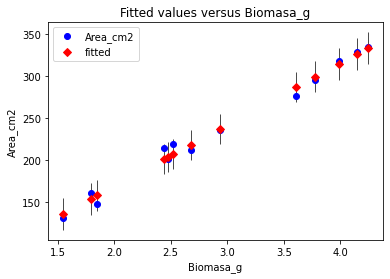

In [ ]:
modelo=ols('Area_cm2 ~ Biomasa_g', data=original.loc[original.loc[:,'Especie']=='Caracoli',:]).fit()
grafico=sm.graphics.plot_fit(modelo,1)


# Resultados PM 2.5 y 10 vs Area

Inicialmente se penso hacer regresiones entre individuos por especie, al hacerse esas regresiones se observa que ninguna es buena la verdad, ni en R2 ni en significancia de los coeficientes de regresion, lo que sugiere que no hay una relacion area material particulado por especie. 

Hay varios factores que afectan la captura de material particulado por un arbol, entre ellos la posicion relativa a las fuentes de emision, la forma de la hoja,caracteristicas fisicas de la hoja entre otras. 

In [ ]:
data_mp=pd.read_excel(r"Base_completa_AREA_.xlsx")
data_mp,ignorados=regresion_material25_spp(data_mp)
data_mp

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


,Especie,R2,numero_individuos,area_coef_25,intercept_25,pval_coef_25,pval_intercept_25,pval_norm
0,Acasia,0.114144,10,-5.148869e-06,0.033438,0.373885,0.022391,0.193895
1,Arizá,0.098775,10,-6.769565e-06,0.172498,0.410130,0.105977,0.549585
2,Azuceno,0.042630,6,-1.463764e-05,0.057103,0.694696,0.161788,0.615784
3,Bucaro,0.759782,8,-6.219882e-05,0.251109,0.004790,0.000920,0.660635
4,Caimo,0.022439,7,9.351499e-06,0.026820,0.748541,0.541757,0.0588268
5,Cambulo,0.232886,7,2.820854e-05,0.036885,0.272707,0.682394,0.749722
6,Caracoli,0.470567,4,-1.423287e-05,0.108204,0.314021,0.134712,0.316309
7,Carbonero,0.187259,9,1.047477e-04,0.001037,0.244678,0.927349,0.0610922
8,Casco de vaca,0.262544,10,7.719334e-06,0.014736,0.158428,0.066210,0.233125
9,Ebano,1.000000,3,3.329504e-06,0.008061,NaN,NaN,Individuos_bajo


Despues se intento hacer una regresion global de los datos, con resultados mas satisfactorios, los R2 de la regresion para PM 2.5 y PM 10 son bajos pero los coeficientes de regresion son significativos en ambos casos, sugiriendo que si hay un efecto del area sobre la captura de material particulado 2.5 y 10 pero que solo es evidente al analizar la tendencia de todos los datos presentes

In [ ]:
data_mp=pd.read_excel(r"Base_completa_AREA_.xlsx")
reg_results,data_mp=regresion_global(data_mp)
reg_results

,numero_individuos,R2_25,area_coef_25,intercept_25,pval_coef_25,pval_intercept_25,pval_norm_25,R2_10,area_coef_10,intercept_10,pval_coef_10,pval_intercept_10,pval_norm_10
0,234,0.138296,0.000005,0.028166,4.354884e-09,1.012627e-16,4.507277e-19,0.261855,0.00003,0.051033,5.117208e-17,0.000057,6.255779e-19


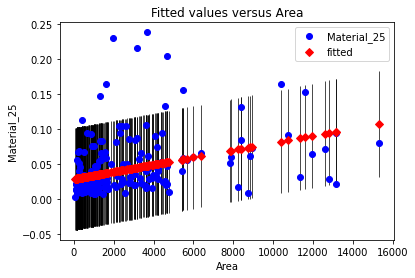

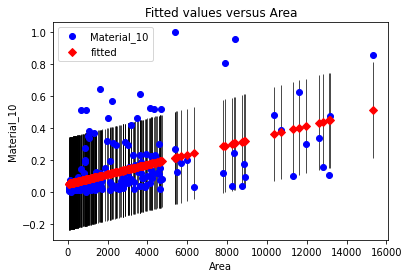

In [ ]:
modelo_25=ols('Material_25 ~ Area', data=data_mp).fit()
modelo_10=ols('Material_10 ~ Area', data=data_mp).fit()

graph_25=sm.graphics.plot_fit(modelo_25,1)
graph_10=sm.graphics.plot_fit(modelo_10,1)

In [ ]:
data_mp.loc[data_mp.loc[:,'Nombre_comun']=='Acasi',:]

,Unnamed: 0,Número del Individuo,Nombre_comun,Material_25,Material_10,Diametro,BiomasaEstimada,Altura,n_Individuos,Area


# Union y estimacion final

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

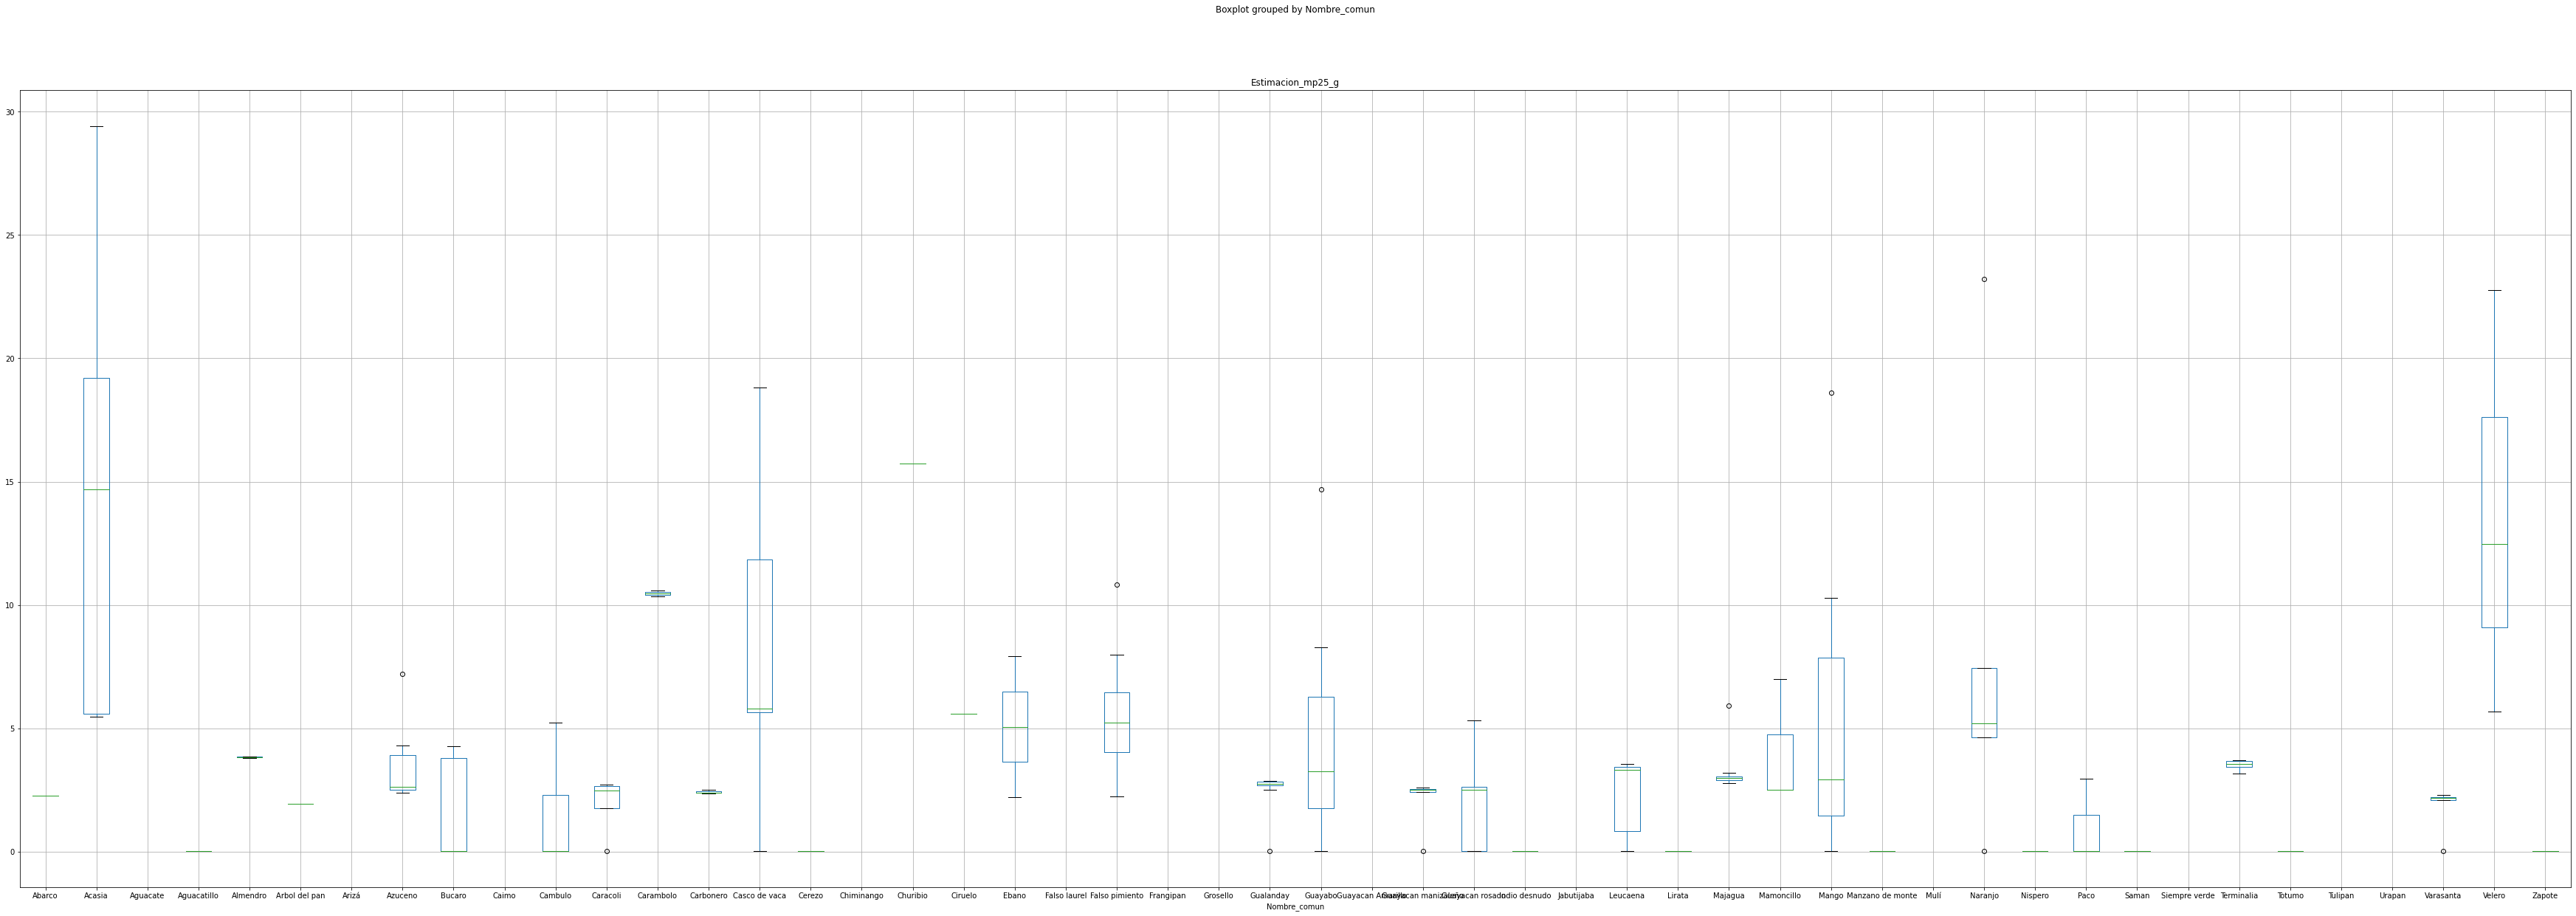

In [ ]:
data=pd.read_excel(r"basedatos_AREABIOMASA_4.xlsx")
data_mp=pd.read_excel(r"Base_completa_AREA_.xlsx")

data_mp=estimacion_modelos(data,data_mp)
data_mp.boxplot(column= 'Estimacion_mp25_g',by='Nombre_comun',figsize=(60,20))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2140da6c18>,
      dtype=object)

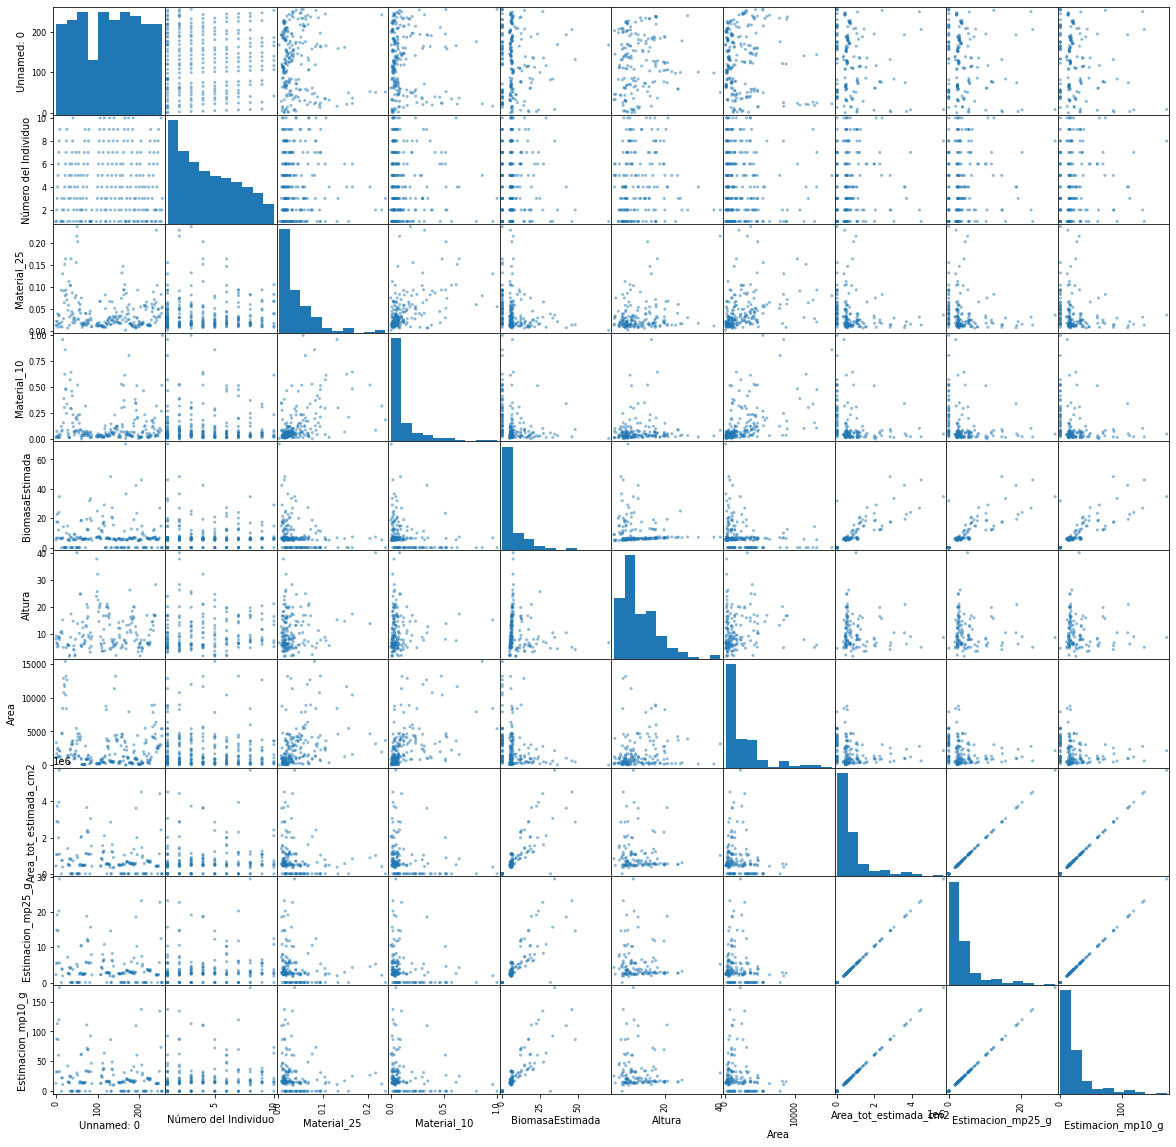

In [ ]:
data_mp.drop(columns=['n_Individuos','Nombre_comun'],inplace=True)

pd.plotting.scatter_matrix(data_mp,figsize=(20,20))